> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, we randomly sample $T \times 4 = 512 \times 4$ grid points of a solution of the ASDM for a $32 \times 32$ grid, integerated for 0 to 50000 for $T = 512$ time steps. 

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model, however, we are looking for the lowest possible number of points that is enough to train the model. On average, 4 data point exists for each time step, around 4/1024=0.391% of the data. 

> It seems that this is the minimum number of data points that one requres to find the correct solution of the  PDE. To clarify, we must consider that the PDE constrains eventually find a solution by reduccing the loss such that the trained NN satisfies the PDE. However, when the observed data points are not enough, the trained model get closer to a different solution and it seems it is not easy to get out of the loss functions's local minimum. Based on the experiment in this notebook, four data points per snapshot (or a $32 \times 32$ grid) is the lower bound.

> We also randomly select $T \times 32 \times 2 = 512 \times 32 \times 2 = 32768$ points in $(x,t,y)$ space and define a second PDE loss function over them. These are points that there is no observed value corresponds to them.

In [1]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs

In [93]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s,
                 X_f, Y_f, T_f, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s
            
            self.X_f = X_f
            self.Y_f = Y_f
            self.T_f = T_f
                        
            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32)#tf.Variable([0.005], dtype=tf.float32)
            self.D_s = tf.constant(0.2, dtype=tf.float32)#tf.Variable([0.2], dtype=tf.float32)
            self.sigma_a = tf.constant(0.0, dtype=tf.float32)#tf.Variable([0.0], dtype=tf.float32)
            self.sigma_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([0.25], dtype=tf.float32)

            # tf placeholders and graph
            self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                         log_device_placement=True))

            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
            self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
            self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

            self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
            self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")
            
            self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.X_f.shape[1]], name="x_f_tf")
            self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.Y_f.shape[1]], name="y_f_tf")
            self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.T_f.shape[1]], name="t_f_tf")            
            
            
            self.a_f_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_f_tf")
            self.s_f_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_f_tf")
                        

            self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)
            
            _, _, self.a_f_tf, self.s_f_tf = self.net_ASDM(self.x_f_tf, self.y_f_tf, self.t_f_tf)
            
            _, _, self.a_f_tf, self.s_f_tf = self.net_ASDM(self.x_f_tf, self.y_f_tf, self.t_f_tf)

            self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

            self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

            self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
            
            self.loss_a_f = tf.reduce_sum(tf.square(self.a_f_tf), name = "loss_a_f")
            
            self.loss_s_f = tf.reduce_sum(tf.square(self.s_f_tf), name = "loss_s_f")

            self.loss = self.loss_1 + self.loss_a + self.loss_s + self.loss_a_f + self.loss_s_f       

            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                    method = 'L-BFGS-B', 
                                                                    options = {'maxiter': 50000,
                                                                               'maxfun': 50000,
                                                                               'maxcor': 50,
                                                                               'maxls': 50,
                                                                               'ftol' : 1.0 * np.finfo(float).eps})        

            self.optimizer_Adam = tf.train.AdamOptimizer()
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    

            init = tf.global_variables_initializer()
            self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss},\n"
              f"D_a: {D_a:.4f}, D_s: {D_s:.4f}\n"
              f"sigma_a: {sigma_a:.4f}, sigma_s: {sigma_s:.4f}\n"
              f"rho_a: {rho_a:.4f}, rho_s: {rho_s:.4f}\n"
              f"mu_a: {mu_a:.4f}, kappa_a: {kappa_a:.4f}\n")
        
      
    def train(self, nIter, early_stop_thresh = None): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s,
                   self.x_f_tf: self.X_f, self.y_f_tf: self.Y_f, self.t_f_tf: self.T_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                loss_a_f_value = self.sess.run(self.loss_a_f, tf_dict)
                loss_s_f_value = self.sess.run(self.loss_s_f, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"          loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      f"          loss_a_f: {loss_a_f_value:.8f}, loss_s_f: {loss_s_f_value:.8f}\n"
                      f"          loss_a_f/N: {loss_a_f_value/N:.8f}, loss_s_f/N: {loss_s_f_value/N:.8f}\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                loss_a_f_value = self.sess.run(self.loss_a_f, tf_dict)
                loss_s_f_value = self.sess.run(self.loss_s_f, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"          loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      f"          loss_a_f: {loss_a_f_value:.8f}, loss_s_f: {loss_s_f_value:.8f}\n"
                      f"          loss_a_f/N: {loss_a_f_value/N:.8f}, loss_s_f/N: {loss_s_f_value/N:.8f}\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss, self.D_a, self.D_s,
        #                                  self.sigma_a, self.sigma_s,
        #                                  self.rho_a, self.rho_s,
        #                                  self.mu_a, self.kappa_a],
        #                        loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [147]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
idx = np.random.choice(N*T, T*4, replace=False)
#idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]


idx2 = np.random.choice(N*T, T*32*2, replace=False)
x_f_train = x[idx2,:]
y_f_train = y[idx2,:]
t_f_train = t[idx2,:]



In [148]:
s_train.shape

(2048, 1)

In [149]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, 
                          x_f_train, y_f_train, t_f_train, layers)
model.train(400000, early_stop_thresh=1000.0)

It: 0, loss_a  : 0.00018096, loss_s  : 0.81935138, loss  : 5722.17,
          loss_a/N: 0.00000009, loss_s/N: 0.00040007, loss/N: 2.79402614,
          loss_a_f: 0.00287855, loss_s_f: 13.10975647
          loss_a_f/N: 0.00000141, loss_s_f/N: 0.00640125
Time:7.38

##################################################
         Early stop
##################################################
It: 15, loss_a  : 0.01266566, loss_s  : 0.09456076, loss  : 742.05,
          loss_a/N: 0.00000618, loss_s/N: 0.00004617, loss/N: 0.36233008,
          loss_a_f: 0.20367767, loss_s_f: 1.52259541
          loss_a_f/N: 0.00009945, loss_s_f/N: 0.00074345
Time:16.79



In [156]:
model.train(400000, early_stop_thresh=100.0)

It: 0, loss_a  : 0.00204431, loss_s  : 0.00545049, loss  : 587.01,
          loss_a/N: 0.00000100, loss_s/N: 0.00000266, loss/N: 0.28662708,
          loss_a_f: 0.03321442, loss_s_f: 0.09023057
          loss_a_f/N: 0.00001622, loss_s_f/N: 0.00004406
Time:1.09

It: 100, loss_a  : 0.00019784, loss_s  : 0.00242670, loss  : 530.68,
          loss_a/N: 0.00000010, loss_s/N: 0.00000118, loss/N: 0.25912222,
          loss_a_f: 0.00315483, loss_s_f: 0.03921651
          loss_a_f/N: 0.00000154, loss_s_f/N: 0.00001915
Time:113.19

It: 200, loss_a  : 0.00014116, loss_s  : 0.00195887, loss  : 530.21,
          loss_a/N: 0.00000007, loss_s/N: 0.00000096, loss/N: 0.25889027,
          loss_a_f: 0.00225455, loss_s_f: 0.03174421
          loss_a_f/N: 0.00000110, loss_s_f/N: 0.00001550
Time:109.58

It: 300, loss_a  : 0.00012779, loss_s  : 0.00182294, loss  : 529.89,
          loss_a/N: 0.00000006, loss_s/N: 0.00000089, loss/N: 0.25873581,
          loss_a_f: 0.00203819, loss_s_f: 0.02953517
          

It: 3100, loss_a  : 0.00053120, loss_s  : 0.02827008, loss  : 472.83,
          loss_a/N: 0.00000026, loss_s/N: 0.00001380, loss/N: 0.23087494,
          loss_a_f: 0.00841318, loss_s_f: 0.44839680
          loss_a_f/N: 0.00000411, loss_s_f/N: 0.00021894
Time:112.11

It: 3200, loss_a  : 0.00055967, loss_s  : 0.03044628, loss  : 469.45,
          loss_a/N: 0.00000027, loss_s/N: 0.00001487, loss/N: 0.22922346,
          loss_a_f: 0.00892841, loss_s_f: 0.48784113
          loss_a_f/N: 0.00000436, loss_s_f/N: 0.00023820
Time:112.46

It: 3300, loss_a  : 0.00059123, loss_s  : 0.03284340, loss  : 465.83,
          loss_a/N: 0.00000029, loss_s/N: 0.00001604, loss/N: 0.22745796,
          loss_a_f: 0.00952005, loss_s_f: 0.53090149
          loss_a_f/N: 0.00000465, loss_s_f/N: 0.00025923
Time:108.25

It: 3400, loss_a  : 0.00078403, loss_s  : 0.04294068, loss  : 466.14,
          loss_a/N: 0.00000038, loss_s/N: 0.00002097, loss/N: 0.22760689,
          loss_a_f: 0.01249967, loss_s_f: 0.68087816
  

It: 6200, loss_a  : 0.00163657, loss_s  : 0.12255043, loss  : 102.41,
          loss_a/N: 0.00000080, loss_s/N: 0.00005984, loss/N: 0.05000679,
          loss_a_f: 0.03065726, loss_s_f: 2.00101948
          loss_a_f/N: 0.00001497, loss_s_f/N: 0.00097706
Time:107.21

##################################################
         Early stop
##################################################
It: 6231, loss_a  : 0.00164385, loss_s  : 0.12282097, loss  : 99.86,
          loss_a/N: 0.00000080, loss_s/N: 0.00005997, loss/N: 0.04875908,
          loss_a_f: 0.03064406, loss_s_f: 1.99999690
          loss_a_f/N: 0.00001496, loss_s_f/N: 0.00097656
Time:33.23



In [163]:
model.train(400000, early_stop_thresh=10.0)

It: 0, loss_a  : 0.00166290, loss_s  : 0.12371682, loss  : 100.43,
          loss_a/N: 0.00000081, loss_s/N: 0.00006041, loss/N: 0.04904045,
          loss_a_f: 0.03119555, loss_s_f: 2.01280522
          loss_a_f/N: 0.00001523, loss_s_f/N: 0.00098282
Time:1.28

It: 100, loss_a  : 0.00170567, loss_s  : 0.12768745, loss  : 93.37,
          loss_a/N: 0.00000083, loss_s/N: 0.00006235, loss/N: 0.04558899,
          loss_a_f: 0.03215763, loss_s_f: 2.02651358
          loss_a_f/N: 0.00001570, loss_s_f/N: 0.00098951
Time:110.36

It: 200, loss_a  : 0.00168553, loss_s  : 0.12744756, loss  : 83.75,
          loss_a/N: 0.00000082, loss_s/N: 0.00006223, loss/N: 0.04089493,
          loss_a_f: 0.03149570, loss_s_f: 2.00356579
          loss_a_f/N: 0.00001538, loss_s_f/N: 0.00097830
Time:109.27

It: 300, loss_a  : 0.00169286, loss_s  : 0.12855700, loss  : 76.91,
          loss_a/N: 0.00000083, loss_s/N: 0.00006277, loss/N: 0.03755377,
          loss_a_f: 0.03174211, loss_s_f: 1.99741971
          los

It: 3100, loss_a  : 0.00109555, loss_s  : 0.08727342, loss  : 16.41,
          loss_a/N: 0.00000053, loss_s/N: 0.00004261, loss/N: 0.00801275,
          loss_a_f: 0.02856512, loss_s_f: 1.46375370
          loss_a_f/N: 0.00001395, loss_s_f/N: 0.00071472
Time:107.10

It: 3200, loss_a  : 0.00109421, loss_s  : 0.08613200, loss  : 15.45,
          loss_a/N: 0.00000053, loss_s/N: 0.00004206, loss/N: 0.00754416,
          loss_a_f: 0.02922269, loss_s_f: 1.44826269
          loss_a_f/N: 0.00001427, loss_s_f/N: 0.00070716
Time:107.23

It: 3300, loss_a  : 0.00108820, loss_s  : 0.08546293, loss  : 15.01,
          loss_a/N: 0.00000053, loss_s/N: 0.00004173, loss/N: 0.00733059,
          loss_a_f: 0.02912664, loss_s_f: 1.43436420
          loss_a_f/N: 0.00001422, loss_s_f/N: 0.00070037
Time:107.19

It: 3400, loss_a  : 0.00107054, loss_s  : 0.08478165, loss  : 14.55,
          loss_a/N: 0.00000052, loss_s/N: 0.00004140, loss/N: 0.00710389,
          loss_a_f: 0.02861326, loss_s_f: 1.41987038
      

In [170]:
model.train(400000, early_stop_thresh=3.2)

It: 0, loss_a  : 0.00094340, loss_s  : 0.07563221, loss  : 9.98,
          loss_a/N: 0.00000046, loss_s/N: 0.00003693, loss/N: 0.00487277,
          loss_a_f: 0.02603003, loss_s_f: 1.25340843
          loss_a_f/N: 0.00001271, loss_s_f/N: 0.00061202
Time:1.10

It: 100, loss_a  : 0.00093468, loss_s  : 0.07507733, loss  : 9.79,
          loss_a/N: 0.00000046, loss_s/N: 0.00003666, loss/N: 0.00477894,
          loss_a_f: 0.02575758, loss_s_f: 1.24354708
          loss_a_f/N: 0.00001258, loss_s_f/N: 0.00060720
Time:119.33

It: 200, loss_a  : 0.00094221, loss_s  : 0.07460808, loss  : 9.92,
          loss_a/N: 0.00000046, loss_s/N: 0.00003643, loss/N: 0.00484237,
          loss_a_f: 0.02637077, loss_s_f: 1.23864865
          loss_a_f/N: 0.00001288, loss_s_f/N: 0.00060481
Time:111.41

It: 300, loss_a  : 0.00092994, loss_s  : 0.07409228, loss  : 9.41,
          loss_a/N: 0.00000045, loss_s/N: 0.00003618, loss/N: 0.00459332,
          loss_a_f: 0.02591272, loss_s_f: 1.22880435
          loss_a_f

It: 3100, loss_a  : 0.00079495, loss_s  : 0.06311256, loss  : 5.69,
          loss_a/N: 0.00000039, loss_s/N: 0.00003082, loss/N: 0.00278072,
          loss_a_f: 0.02240806, loss_s_f: 1.04389381
          loss_a_f/N: 0.00001094, loss_s_f/N: 0.00050971
Time:110.16

It: 3200, loss_a  : 0.00079281, loss_s  : 0.06278478, loss  : 5.62,
          loss_a/N: 0.00000039, loss_s/N: 0.00003066, loss/N: 0.00274265,
          loss_a_f: 0.02237536, loss_s_f: 1.03889751
          loss_a_f/N: 0.00001093, loss_s_f/N: 0.00050727
Time:107.81

It: 3300, loss_a  : 0.00078885, loss_s  : 0.06250778, loss  : 5.55,
          loss_a/N: 0.00000039, loss_s/N: 0.00003052, loss/N: 0.00271126,
          loss_a_f: 0.02227134, loss_s_f: 1.03394198
          loss_a_f/N: 0.00001087, loss_s_f/N: 0.00050485
Time:107.51

It: 3400, loss_a  : 0.00078606, loss_s  : 0.06223729, loss  : 5.47,
          loss_a/N: 0.00000038, loss_s/N: 0.00003039, loss/N: 0.00267141,
          loss_a_f: 0.02222429, loss_s_f: 1.03006864
          

It: 6200, loss_a  : 0.00071291, loss_s  : 0.05578751, loss  : 3.93,
          loss_a/N: 0.00000035, loss_s/N: 0.00002724, loss/N: 0.00191822,
          loss_a_f: 0.02028526, loss_s_f: 0.92821813
          loss_a_f/N: 0.00000990, loss_s_f/N: 0.00045323
Time:113.92

It: 6300, loss_a  : 0.00072830, loss_s  : 0.05588362, loss  : 5.18,
          loss_a/N: 0.00000036, loss_s/N: 0.00002729, loss/N: 0.00253044,
          loss_a_f: 0.02148781, loss_s_f: 0.93784666
          loss_a_f/N: 0.00001049, loss_s_f/N: 0.00045793
Time:121.20

It: 6400, loss_a  : 0.00076334, loss_s  : 0.05699938, loss  : 6.83,
          loss_a/N: 0.00000037, loss_s/N: 0.00002783, loss/N: 0.00333534,
          loss_a_f: 0.02200326, loss_s_f: 0.95692515
          loss_a_f/N: 0.00001074, loss_s_f/N: 0.00046725
Time:110.93

It: 6500, loss_a  : 0.00070668, loss_s  : 0.05518216, loss  : 3.81,
          loss_a/N: 0.00000035, loss_s/N: 0.00002694, loss/N: 0.00186153,
          loss_a_f: 0.02013000, loss_s_f: 0.91907942
          

In [187]:
model.train(400000, early_stop_thresh=1.0)

It: 0, loss_a  : 0.00066764, loss_s  : 0.05156910, loss  : 3.20,
          loss_a/N: 0.00000033, loss_s/N: 0.00002518, loss/N: 0.00156053,
          loss_a_f: 0.01894846, loss_s_f: 0.86141670
          loss_a_f/N: 0.00000925, loss_s_f/N: 0.00042061
Time:1.10

It: 100, loss_a  : 0.00067436, loss_s  : 0.05146209, loss  : 3.31,
          loss_a/N: 0.00000033, loss_s/N: 0.00002513, loss/N: 0.00161529,
          loss_a_f: 0.01931857, loss_s_f: 0.86172307
          loss_a_f/N: 0.00000943, loss_s_f/N: 0.00042076
Time:129.56

It: 200, loss_a  : 0.00066307, loss_s  : 0.05123321, loss  : 3.14,
          loss_a/N: 0.00000032, loss_s/N: 0.00002502, loss/N: 0.00153526,
          loss_a_f: 0.01882684, loss_s_f: 0.85584390
          loss_a_f/N: 0.00000919, loss_s_f/N: 0.00041789
Time:132.31

It: 300, loss_a  : 0.00066375, loss_s  : 0.05092921, loss  : 3.30,
          loss_a/N: 0.00000032, loss_s/N: 0.00002487, loss/N: 0.00161040,
          loss_a_f: 0.01887246, loss_s_f: 0.85202706
          loss_a_f

It: 3100, loss_a  : 0.00062264, loss_s  : 0.04722826, loss  : 3.22,
          loss_a/N: 0.00000030, loss_s/N: 0.00002306, loss/N: 0.00157313,
          loss_a_f: 0.01744892, loss_s_f: 0.79137158
          loss_a_f/N: 0.00000852, loss_s_f/N: 0.00038641
Time:107.55

It: 3200, loss_a  : 0.00060901, loss_s  : 0.04733209, loss  : 4.24,
          loss_a/N: 0.00000030, loss_s/N: 0.00002311, loss/N: 0.00206852,
          loss_a_f: 0.01675253, loss_s_f: 0.78463113
          loss_a_f/N: 0.00000818, loss_s_f/N: 0.00038312
Time:107.42

It: 3300, loss_a  : 0.00061705, loss_s  : 0.04671889, loss  : 2.52,
          loss_a/N: 0.00000030, loss_s/N: 0.00002281, loss/N: 0.00122948,
          loss_a_f: 0.01753585, loss_s_f: 0.78397530
          loss_a_f/N: 0.00000856, loss_s_f/N: 0.00038280
Time:110.02

It: 3400, loss_a  : 0.00061822, loss_s  : 0.04658243, loss  : 2.59,
          loss_a/N: 0.00000030, loss_s/N: 0.00002275, loss/N: 0.00126595,
          loss_a_f: 0.01770581, loss_s_f: 0.78517377
          

It: 6200, loss_a  : 0.00057828, loss_s  : 0.04314559, loss  : 2.18,
          loss_a/N: 0.00000028, loss_s/N: 0.00002107, loss/N: 0.00106209,
          loss_a_f: 0.01636739, loss_s_f: 0.72683740
          loss_a_f/N: 0.00000799, loss_s_f/N: 0.00035490
Time:107.12

It: 6300, loss_a  : 0.00057697, loss_s  : 0.04305565, loss  : 2.15,
          loss_a/N: 0.00000028, loss_s/N: 0.00002102, loss/N: 0.00104827,
          loss_a_f: 0.01634659, loss_s_f: 0.72570622
          loss_a_f/N: 0.00000798, loss_s_f/N: 0.00035435
Time:107.03

It: 6400, loss_a  : 0.00057846, loss_s  : 0.04296627, loss  : 2.11,
          loss_a/N: 0.00000028, loss_s/N: 0.00002098, loss/N: 0.00103048,
          loss_a_f: 0.01645632, loss_s_f: 0.72560894
          loss_a_f/N: 0.00000804, loss_s_f/N: 0.00035430
Time:107.16

It: 6500, loss_a  : 0.00058136, loss_s  : 0.04297384, loss  : 2.19,
          loss_a/N: 0.00000028, loss_s/N: 0.00002098, loss/N: 0.00106768,
          loss_a_f: 0.01662266, loss_s_f: 0.72771394
          

It: 9300, loss_a  : 0.00054847, loss_s  : 0.04001729, loss  : 1.84,
          loss_a/N: 0.00000027, loss_s/N: 0.00001954, loss/N: 0.00089743,
          loss_a_f: 0.01559534, loss_s_f: 0.68012118
          loss_a_f/N: 0.00000761, loss_s_f/N: 0.00033209
Time:107.17

It: 9400, loss_a  : 0.00054909, loss_s  : 0.04000113, loss  : 2.14,
          loss_a/N: 0.00000027, loss_s/N: 0.00001953, loss/N: 0.00104266,
          loss_a_f: 0.01550079, loss_s_f: 0.67986619
          loss_a_f/N: 0.00000757, loss_s_f/N: 0.00033197
Time:107.14

It: 9500, loss_a  : 0.00054141, loss_s  : 0.03990535, loss  : 2.25,
          loss_a/N: 0.00000026, loss_s/N: 0.00001949, loss/N: 0.00109956,
          loss_a_f: 0.01513026, loss_s_f: 0.67444301
          loss_a_f/N: 0.00000739, loss_s_f/N: 0.00032932
Time:107.13

It: 9600, loss_a  : 0.00054705, loss_s  : 0.03974678, loss  : 1.87,
          loss_a/N: 0.00000027, loss_s/N: 0.00001941, loss/N: 0.00091525,
          loss_a_f: 0.01556142, loss_s_f: 0.67727292
          

It: 12400, loss_a  : 0.00053113, loss_s  : 0.03783121, loss  : 2.61,
          loss_a/N: 0.00000026, loss_s/N: 0.00001847, loss/N: 0.00127497,
          loss_a_f: 0.01466865, loss_s_f: 0.64237499
          loss_a_f/N: 0.00000716, loss_s_f/N: 0.00031366
Time:107.07

It: 12500, loss_a  : 0.00051843, loss_s  : 0.03725217, loss  : 1.74,
          loss_a/N: 0.00000025, loss_s/N: 0.00001819, loss/N: 0.00084943,
          loss_a_f: 0.01454299, loss_s_f: 0.63506353
          loss_a_f/N: 0.00000710, loss_s_f/N: 0.00031009
Time:107.07

It: 12600, loss_a  : 0.00051964, loss_s  : 0.03709983, loss  : 1.62,
          loss_a/N: 0.00000025, loss_s/N: 0.00001812, loss/N: 0.00079100,
          loss_a_f: 0.01475909, loss_s_f: 0.63584685
          loss_a_f/N: 0.00000721, loss_s_f/N: 0.00031047
Time:107.08

It: 12700, loss_a  : 0.00052005, loss_s  : 0.03703751, loss  : 1.61,
          loss_a/N: 0.00000025, loss_s/N: 0.00001808, loss/N: 0.00078424,
          loss_a_f: 0.01474815, loss_s_f: 0.63489366
      

It: 15500, loss_a  : 0.00050177, loss_s  : 0.03493029, loss  : 1.66,
          loss_a/N: 0.00000025, loss_s/N: 0.00001706, loss/N: 0.00081135,
          loss_a_f: 0.01442466, loss_s_f: 0.60817081
          loss_a_f/N: 0.00000704, loss_s_f/N: 0.00029696
Time:107.09

It: 15600, loss_a  : 0.00049914, loss_s  : 0.03478249, loss  : 1.44,
          loss_a/N: 0.00000024, loss_s/N: 0.00001698, loss/N: 0.00070548,
          loss_a_f: 0.01414762, loss_s_f: 0.60200846
          loss_a_f/N: 0.00000691, loss_s_f/N: 0.00029395
Time:107.07

It: 15700, loss_a  : 0.00049420, loss_s  : 0.03504114, loss  : 2.26,
          loss_a/N: 0.00000024, loss_s/N: 0.00001711, loss/N: 0.00110413,
          loss_a_f: 0.01359673, loss_s_f: 0.59800398
          loss_a_f/N: 0.00000664, loss_s_f/N: 0.00029199
Time:107.08

It: 15800, loss_a  : 0.00049737, loss_s  : 0.03465157, loss  : 1.43,
          loss_a/N: 0.00000024, loss_s/N: 0.00001692, loss/N: 0.00069681,
          loss_a_f: 0.01412146, loss_s_f: 0.60004056
      

It: 18600, loss_a  : 0.00048334, loss_s  : 0.03301690, loss  : 2.34,
          loss_a/N: 0.00000024, loss_s/N: 0.00001612, loss/N: 0.00114060,
          loss_a_f: 0.01346595, loss_s_f: 0.57432497
          loss_a_f/N: 0.00000658, loss_s_f/N: 0.00028043
Time:107.12

It: 18700, loss_a  : 0.00048743, loss_s  : 0.03286499, loss  : 1.51,
          loss_a/N: 0.00000024, loss_s/N: 0.00001605, loss/N: 0.00073595,
          loss_a_f: 0.01392989, loss_s_f: 0.57703716
          loss_a_f/N: 0.00000680, loss_s_f/N: 0.00028176
Time:107.15

It: 18800, loss_a  : 0.00047978, loss_s  : 0.03266054, loss  : 1.29,
          loss_a/N: 0.00000023, loss_s/N: 0.00001595, loss/N: 0.00063213,
          loss_a_f: 0.01359803, loss_s_f: 0.57061529
          loss_a_f/N: 0.00000664, loss_s_f/N: 0.00027862
Time:107.24

It: 18900, loss_a  : 0.00048245, loss_s  : 0.03273476, loss  : 1.50,
          loss_a/N: 0.00000024, loss_s/N: 0.00001598, loss/N: 0.00073479,
          loss_a_f: 0.01366964, loss_s_f: 0.57376289
      

It: 21700, loss_a  : 0.00049422, loss_s  : 0.03256240, loss  : 4.34,
          loss_a/N: 0.00000024, loss_s/N: 0.00001590, loss/N: 0.00211827,
          loss_a_f: 0.01390041, loss_s_f: 0.57084382
          loss_a_f/N: 0.00000679, loss_s_f/N: 0.00027873
Time:107.19

It: 21800, loss_a  : 0.00047284, loss_s  : 0.03103564, loss  : 1.47,
          loss_a/N: 0.00000023, loss_s/N: 0.00001515, loss/N: 0.00071607,
          loss_a_f: 0.01349903, loss_s_f: 0.55018497
          loss_a_f/N: 0.00000659, loss_s_f/N: 0.00026865
Time:106.98

It: 21900, loss_a  : 0.00045720, loss_s  : 0.03105373, loss  : 1.96,
          loss_a/N: 0.00000022, loss_s/N: 0.00001516, loss/N: 0.00095739,
          loss_a_f: 0.01271595, loss_s_f: 0.54058743
          loss_a_f/N: 0.00000621, loss_s_f/N: 0.00026396
Time:107.00

It: 22000, loss_a  : 0.00046249, loss_s  : 0.03077904, loss  : 1.22,
          loss_a/N: 0.00000023, loss_s/N: 0.00001503, loss/N: 0.00059435,
          loss_a_f: 0.01311119, loss_s_f: 0.54246557
      

It: 24800, loss_a  : 0.00044670, loss_s  : 0.02945153, loss  : 1.44,
          loss_a/N: 0.00000022, loss_s/N: 0.00001438, loss/N: 0.00070206,
          loss_a_f: 0.01242147, loss_s_f: 0.51731634
          loss_a_f/N: 0.00000607, loss_s_f/N: 0.00025260
Time:107.21

It: 24900, loss_a  : 0.00045016, loss_s  : 0.02931141, loss  : 1.16,
          loss_a/N: 0.00000022, loss_s/N: 0.00001431, loss/N: 0.00056705,
          loss_a_f: 0.01276261, loss_s_f: 0.52102697
          loss_a_f/N: 0.00000623, loss_s_f/N: 0.00025441
Time:107.05

It: 25000, loss_a  : 0.00044993, loss_s  : 0.02933826, loss  : 1.19,
          loss_a/N: 0.00000022, loss_s/N: 0.00001433, loss/N: 0.00058286,
          loss_a_f: 0.01273466, loss_s_f: 0.52033526
          loss_a_f/N: 0.00000622, loss_s_f/N: 0.00025407
Time:107.12

It: 25100, loss_a  : 0.00045671, loss_s  : 0.02943473, loss  : 1.43,
          loss_a/N: 0.00000022, loss_s/N: 0.00001437, loss/N: 0.00070045,
          loss_a_f: 0.01306907, loss_s_f: 0.52578127
      

It: 27900, loss_a  : 0.00043813, loss_s  : 0.02804731, loss  : 1.01,
          loss_a/N: 0.00000021, loss_s/N: 0.00001369, loss/N: 0.00049477,
          loss_a_f: 0.01230552, loss_s_f: 0.49796265
          loss_a_f/N: 0.00000601, loss_s_f/N: 0.00024315
Time:107.20

It: 28000, loss_a  : 0.00043808, loss_s  : 0.02799650, loss  : 1.01,
          loss_a/N: 0.00000021, loss_s/N: 0.00001367, loss/N: 0.00049413,
          loss_a_f: 0.01230598, loss_s_f: 0.49741304
          loss_a_f/N: 0.00000601, loss_s_f/N: 0.00024288
Time:107.26

It: 28100, loss_a  : 0.00044138, loss_s  : 0.02807087, loss  : 1.06,
          loss_a/N: 0.00000022, loss_s/N: 0.00001371, loss/N: 0.00051726,
          loss_a_f: 0.01243229, loss_s_f: 0.49979126
          loss_a_f/N: 0.00000607, loss_s_f/N: 0.00024404
Time:107.17

It: 28200, loss_a  : 0.00043791, loss_s  : 0.02797996, loss  : 1.03,
          loss_a/N: 0.00000021, loss_s/N: 0.00001366, loss/N: 0.00050449,
          loss_a_f: 0.01225210, loss_s_f: 0.49601144
      

In [188]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = 320#T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[:T_2]#t_star[-T_2:]

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [189]:
x_2.shape

(327680, 1)

In [190]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2,
           model.x_f_tf: x_2, model.y_f_tf: y_2, model.t_f_tf: t_2}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_a_f_2 = model.sess.run(model.loss_a_f, tf_dict)
l_s_f_2 = model.sess.run(model.loss_s_f, tf_dict)


print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss_a_f : {l_a_f_2:.8f}")
print( f"Loss_s_f : {l_s_f_2:.8f}")


Loss_a : 0.13726223
Loss_s : 5.63499451
Loss_a_f : 0.13726223
Loss_s_f : 5.63499451


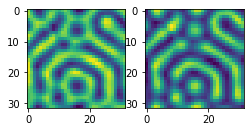

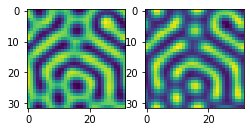

In [191]:
start = 319
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, start].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, start].reshape((x_size,y_size)))
plt.show()

#plt.subplot(131)
#plt.imshow(data[0, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.subplot(132)
#plt.imshow(data[1, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.show()

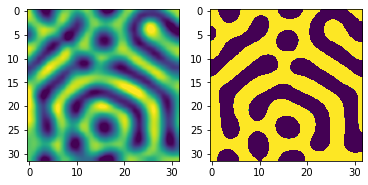

In [192]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)), interpolation='gaussian')

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)), interpolation='gaussian')
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_sparse.gif', writer='imagemagick')

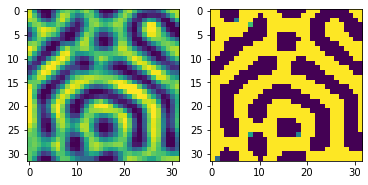

In [193]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)))

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)))
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_sparse_2.gif', writer='imagemagick')

In [202]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = 60000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [203]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis],
           model.x_f_tf: x_2, model.y_f_tf: y_2, model.t_f_tf: t_2}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00745211
Loss_s : 0.11186656
Loss   : 357.56930542


In [204]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

335.572016116465
21.758623333633523


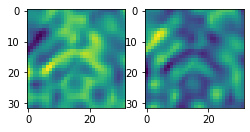

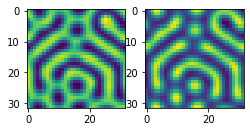

In [205]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [206]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_sampled_random', global_step=0)

'./PINN_Turring_model_loss_sampled_random-0'

In [207]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_3:0
y_tf_3:0
t_tf_3:0
a_pred_6:0
s_pred_6:0
add_103:0
loss_a_3:0
loss_s_3:0
